In [1]:
import torch
import torchvision
import os
import pickle
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
from torchcam.methods import SmoothGradCAMpp
from utils import imread, isfile, im_to_txt_path
from timer import *
from torchvision.transforms import transforms as T
import cv2
import numpy as np
import random

parent_dir = 'rois2/'
obj_dir = parent_dir + 'objects/'
img_dir = parent_dir + 'images/'
label_dir = parent_dir + 'labels/'
model_dir = parent_dir + 'models/'

obj_train_dir = obj_dir + 'train/'
obj_val_dir = obj_dir + 'val/'

result_dir = parent_dir + 'results/'
os.makedirs(result_dir, exist_ok=True)
model1_result_dir = result_dir + 'model1/'
os.makedirs(model1_result_dir, exist_ok=True)
model2_result_dir = result_dir + 'model2/'
os.makedirs(model2_result_dir, exist_ok=True)

bkg = 0


In [ ]:
mean_std_dict = pickle.load(open(img_dir + 'mean_std.pkl', 'rb'))
print(mean_std_dict)

In [ ]:
ratio = []
dirs = os.listdir(obj_train_dir)
for dir in dirs:
    if os.path.isdir(obj_train_dir+ dir):
        # print(len(os.listdir(obj_dir + dir)))
        ratio.append(len(os.listdir(obj_train_dir + dir)))
print(ratio)


In [ ]:
ratio = []
dirs = os.listdir(obj_val_dir)
for dir in dirs:
    if os.path.isdir(obj_val_dir+ dir):
        # print(len(os.listdir(obj_dir + dir)))
        ratio.append(len(os.listdir(obj_val_dir + dir)))
print(ratio)

In [5]:
from PIL import Image
def custom_loader(path):
    return path

orig_train_dataset = datasets.ImageFolder(root=obj_train_dir,loader=custom_loader)

orig_val_dataset = datasets.ImageFolder(root=obj_val_dir,loader=custom_loader)

In [6]:
def crop_name_to_roi_name(crop_name):
    return (crop_name.split('__')[0]).split('\\')[-1]

In [7]:
from collections import Counter
class_num = len(orig_train_dataset.classes)

In [23]:
# # Balance train dataset by extending the minority classes

# print('train dataset: ')
# print('     unbalanced:')

# class_counts = Counter([label for _, label in orig_train_dataset.samples])
# max_count = max(class_counts.values())
# print('     ', class_counts)

# print('     balanced:')
# import random
# # Create a new dataset to store balanced data
# balanced_train_dataset = []

# for label in class_counts:
#     indices = [i for i, (_, lbl) in enumerate(orig_train_dataset.samples) if lbl == label]
    
#     # Calculate how many more samples are needed to balance the class
#     additional_samples_needed = max_count - class_counts[label]
    
#     # Oversample the class by randomly duplicating images
#     if additional_samples_needed > 0:
#         additional_samples = random.choices(indices, k=additional_samples_needed)
#         indices.extend(additional_samples)
    
#     balanced_train_dataset.extend([orig_train_dataset[i] for i in indices])

# # Shuffle the balanced dataset
# random.shuffle(balanced_train_dataset)
# class_counts = Counter([label for _, label in balanced_train_dataset])
# print('     ', class_counts)


In [24]:
# # Balance val dataset by shortening the majority classes
# print('val dataset: ')
# print('     unbalanced:')

# class_counts = Counter([label for _, label in orig_val_dataset.samples])
# min_count = min(class_counts.values())
# print('     ', class_counts)

# print('     balanced:')
# import random
# # Create a new dataset to store balanced data
# balanced_indices = []
# balanced_val_dataset = []
# for label in class_counts:
#     indices = [i for i, (_, lbl) in enumerate(orig_val_dataset.samples) if lbl == label]
    
#     if min_count > 0:
#         balanced_indices.extend(random.choices(indices, k=min_count))
    
# balanced_val_dataset.extend([orig_val_dataset[i] for i in balanced_indices])

# # Shuffle the balanced dataset
# random.shuffle(balanced_val_dataset)
# class_counts = Counter([label for _, label in balanced_val_dataset])
# print('     ', class_counts)

In [29]:
class CustomDataset(Dataset):

    def __init__(self, inputs_list_pos, inputs_list_neg, length, positive_prob = 0.5):
        
        self.positives = inputs_list_pos
        self.negatives = inputs_list_neg
        self.positive_prob = positive_prob
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # print(self.inputs_list[idx])
        item = random.choices([random.choice(self.positives), random.choice(self.negatives)], weights=[self.positive_prob, 1-self.positive_prob],k=1)[0]
        path = item[0]
        roi_name = crop_name_to_roi_name(path)
        if roi_name in mean_std_dict.keys():
            mean, std = mean_std_dict[roi_name]
        else:
            print('mean std not found')
            print(roi_name)
            
        label = item[1]
        image = Image.open(path)
        
        transf = v2.Compose([
            v2.ToImage(), 
            v2.ToDtype(torch.float32, scale=True),
            v2.Resize((260,260)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.RandomAffine(degrees=(0,90), translate=(0.1,0.3), scale=(0.5,0.75)),
            v2.Normalize(mean=mean, std=std), # aim to make the mean = 0 and std = 1
           
        ])
        image = transf(image)

        return image, label

In [33]:
train_dataset_positives = []
train_dataset_negatives = []
for item in orig_train_dataset.samples:
    if item[1] == 1:
        train_dataset_positives.append(item)
    else:
        train_dataset_negatives.append(item)

val_dataset_positives = []
val_dataset_negatives = []
for item in orig_val_dataset.samples:
    if item[1] == 1:
        val_dataset_positives.append(item)
    else:
        val_dataset_negatives.append(item)
        

train_dataset = CustomDataset(train_dataset_positives, train_dataset_negatives,320000)

val_dataset = CustomDataset(val_dataset_positives, val_dataset_negatives, 64000, positive_prob=0.1)

In [ ]:
train_loader, val_loader = DataLoader(train_dataset, batch_size=32, shuffle=False), DataLoader(val_dataset, batch_size=32, shuffle=False)
print('train loader length: ', len(train_loader))
print('val loader length: ', len(val_loader))

In [28]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

def train_classification_model(model, train_loader, val_loader, save_model_dir, begin_epoch = 1,num_epochs=10,class_weights=None, train = True, val = True):
    
    accuracy_list = [None]*num_epochs
    precision_list = [None]*num_epochs
    recall_list = [None]*num_epochs
    train_loss_list = [None]*num_epochs
    learning_rate_list = [None]*num_epochs
    
    model.to('cuda')
    criterion = torch.nn.CrossEntropyLoss(weight = class_weights).to('cuda')
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3
                                  , weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    if begin_epoch > 1:
        model.load_state_dict(torch.load(save_model_dir + 'round3_model_epoch' + str(begin_epoch-1) + '.pth'))
    for epoch in range(begin_epoch, begin_epoch + num_epochs):
        if train:
            # Train the model
            model.train()
            train_loss = 0
            cnt = 0 
            print('Training model...')
            for i, (images, labels) in enumerate(train_loader):
                images = images.to('cuda')
                labels = labels.to('cuda')
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs.float(), labels)
                
                train_loss += loss.item()
                cnt += 1
                
                loss.backward()
                optimizer.step()
                model_path = save_model_dir + 'round3_model_epoch' + str(epoch) + '.pth'
                
                if (i + 1)%500 == 0 or i == len(train_loader)-1:
                    print('     Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Learning Rate: {}'
                        .format(epoch, num_epochs, i+1, len(train_loader), loss.item(), optimizer.param_groups[0]['lr']))
            train_loss /= cnt
            train_loss_list[epoch-1] = train_loss
            learning_rate_list[epoch-1] = optimizer.param_groups[0]['lr']
            torch.save(model.state_dict(), model_path)
        
        if val:    
            model.load_state_dict(torch.load(save_model_dir + 'round3_model_epoch' + str(epoch) + '.pth'))
            # Validation
            model.eval()
            print('Validation...')
            
            # Calculate accuracy
            correct = 0
            total = 0
            # Calculate recall
            true_pos_obj = 0
            correct_pos_pred = 0
            pos_pred = 0
            with torch.no_grad():
                for i, (images, labels) in enumerate(val_loader):
                    images = images.to('cuda')
                    labels = labels.to('cuda')
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    true_pos_obj += (labels != bkg).sum().item()
                    correct_pos_pred += ((predicted == labels) & (labels != bkg)).sum().item()
                    pos_pred += (predicted != bkg).sum().item()
                    
                    if(i+1) % 500 == 0 or i == len(val_loader)-1:
                        print('     Epoch [{}/{}], Image [{}/{}], Accuracy: {:.2f} %, Recall: {:.2f} %, Precision: {:.2f} %'
                                .format(epoch, num_epochs, i+1, len(val_loader), 100 * correct / total, 100 * correct_pos_pred / true_pos_obj, 100 * correct_pos_pred / pos_pred))
                    
            print('\n')        
            print('total: ', total, 'correct: ', correct, 'true_pos_obj: ', true_pos_obj, 'correct_pos_pred: ', correct_pos_pred, 'pos_pred: ', pos_pred)
            print('Accuracy of the network on the validation images: {} % '.format(100 * correct / total))
            print('Recall of the network on the validation images: {} % '.format(100 * correct_pos_pred / true_pos_obj))
            print('Precision of the network on the validation images: {} % '.format(100 * correct_pos_pred / pos_pred))    
            accuracy_list[epoch-1] = correct / total
            pickle.dump(accuracy_list, open(save_model_dir + 'accuracy_list.pkl', 'wb'))
            recall_list[epoch-1] = correct_pos_pred / true_pos_obj
            pickle.dump(recall_list, open(save_model_dir + 'recall_list.pkl', 'wb'))
            precision_list[epoch-1] = correct_pos_pred / pos_pred
            pickle.dump(precision_list, open(save_model_dir + 'precision_list.pkl', 'wb'))
            
            scheduler.step()
            
            list = np.arange(begin_epoch, begin_epoch + num_epochs)
            plt.figure(figsize=(10, 8))
            ax1 = plt.subplot(2, 1, 1)
            plt.xticks(list)
            
            ax1.set_xlabel('Epoch')
            
            ax1.set_ylabel('Percentage')
            ax1.plot(list, accuracy_list, marker='o',label = 'Accuracy', color='tab:red')
            ax1.plot(list, recall_list, marker='o', label = 'Recall', color='tab:orange')
            ax1.plot(list, precision_list, marker='o', label = 'Precision', color='tab:blue')
            ax1.tick_params(axis='y')
            
            ax2 = ax1.twinx()
            ax2.set_ylabel('Learning rate', color='tab:green')
            ax2.plot(list, learning_rate_list, marker='o', label = 'Learning rate', color='tab:green')
            ax2.tick_params(axis='y', labelcolor='tab:green')
            
            ax1.legend(loc='upper left')
            ax2.legend(loc='upper right')
            
            plt.subplot(2, 1, 2)
            plt.plot(list, train_loss_list, marker='o', label = 'Train loss', color='tab:green')
            plt.xlabel('Epoch')
            plt.ylabel('Loss', color='tab:green')
            plt.xticks(list)
            plt.tight_layout()
            plt.show()
            
            plt.close('all')
        
        

In [ ]:
class_model = torchvision.models.efficientnet_b1().to('cuda')
class_model.classifier[1] = nn.Linear(class_model.classifier[1].in_features, 2).to('cuda')
class_model.load_state_dict(torch.load('rois2/models/round3/2024_08_31_lr0.001 decay0.01 ratio1-5/round3_model_epoch19.pth'))

In [ ]:
begin_epoch = 1
num_epochs = 10

class_weights = torch.tensor([1.0, 10.0]).to('cuda')
train_classification_model(model = class_model, train_loader=train_loader, val_loader= val_loader,save_model_dir=model2_result_dir,
                           begin_epoch=begin_epoch,num_epochs=num_epochs,class_weights=None, train=True, val=True)


Epoch [1/10]
     Softmax Threshold [0.5]
         Image [500/2000], Accuracy: 93.67 %, Recall: 95.61 %, Precision: 61.39 %
         Image [1000/2000], Accuracy: 93.49 %, Recall: 95.50 %, Precision: 60.82 %
         Image [1500/2000], Accuracy: 93.40 %, Recall: 95.69 %, Precision: 60.72 %
         Image [2000/2000], Accuracy: 93.42 %, Recall: 95.77 %, Precision: 60.81 %


total:  64000 correct:  59791 true_pos_obj:  6383 correct_pos_pred:  6113 pos_pred:  10052
Accuracy of the network on the validation images: 93.42343749999999 % 
Recall of the network on the validation images: 95.770014099953 % 
Precision of the network on the validation images: 60.813768404297655 % 


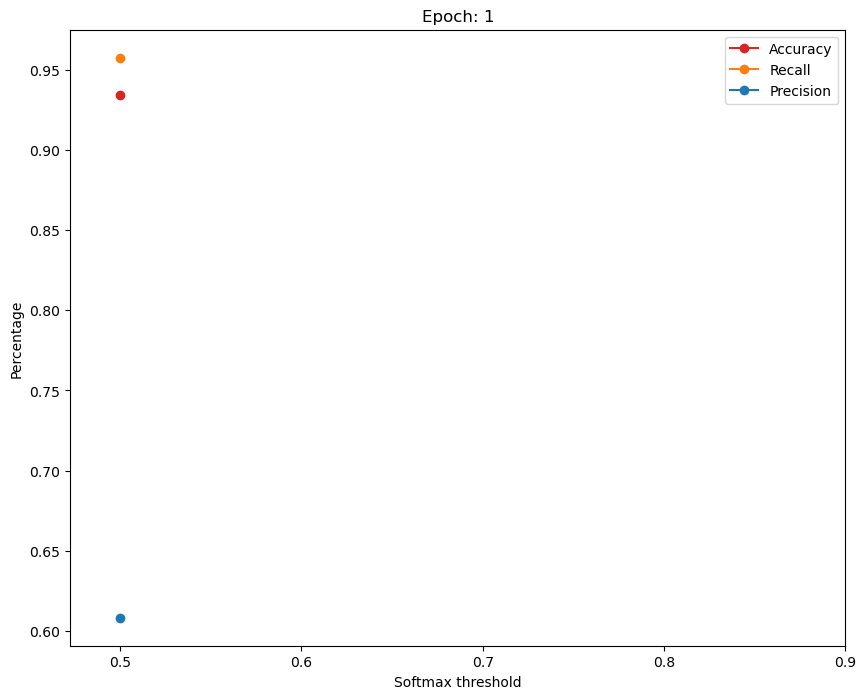

     Softmax Threshold [0.6]
         Image [500/2000], Accuracy: 94.61 %, Recall: 94.64 %, Precision: 65.30 %
         Image [1000/2000], Accuracy: 94.58 %, Recall: 94.32 %, Precision: 65.66 %
         Image [1500/2000], Accuracy: 94.51 %, Recall: 94.31 %, Precision: 65.59 %
         Image [2000/2000], Accuracy: 94.45 %, Recall: 94.39 %, Precision: 65.28 %


total:  64000 correct:  60445 true_pos_obj:  6369 correct_pos_pred:  6012 pos_pred:  9210
Accuracy of the network on the validation images: 94.4453125 % 
Recall of the network on the validation images: 94.39472444653791 % 
Precision of the network on the validation images: 65.27687296416939 % 


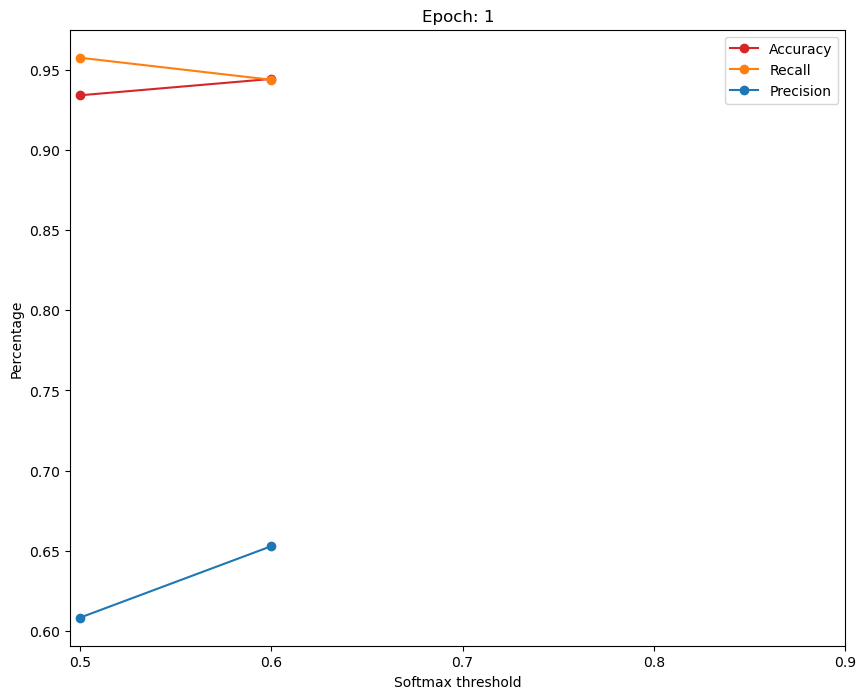

     Softmax Threshold [0.7]
         Image [500/2000], Accuracy: 94.96 %, Recall: 91.45 %, Precision: 67.67 %
         Image [1000/2000], Accuracy: 95.00 %, Recall: 91.84 %, Precision: 68.28 %
         Image [1500/2000], Accuracy: 95.03 %, Recall: 92.02 %, Precision: 68.67 %
         Image [2000/2000], Accuracy: 95.08 %, Recall: 91.94 %, Precision: 68.92 %


total:  64000 correct:  60853 true_pos_obj:  6354 correct_pos_pred:  5842 pos_pred:  8477
Accuracy of the network on the validation images: 95.0828125 % 
Recall of the network on the validation images: 91.94208372678628 % 
Precision of the network on the validation images: 68.91589005544414 % 


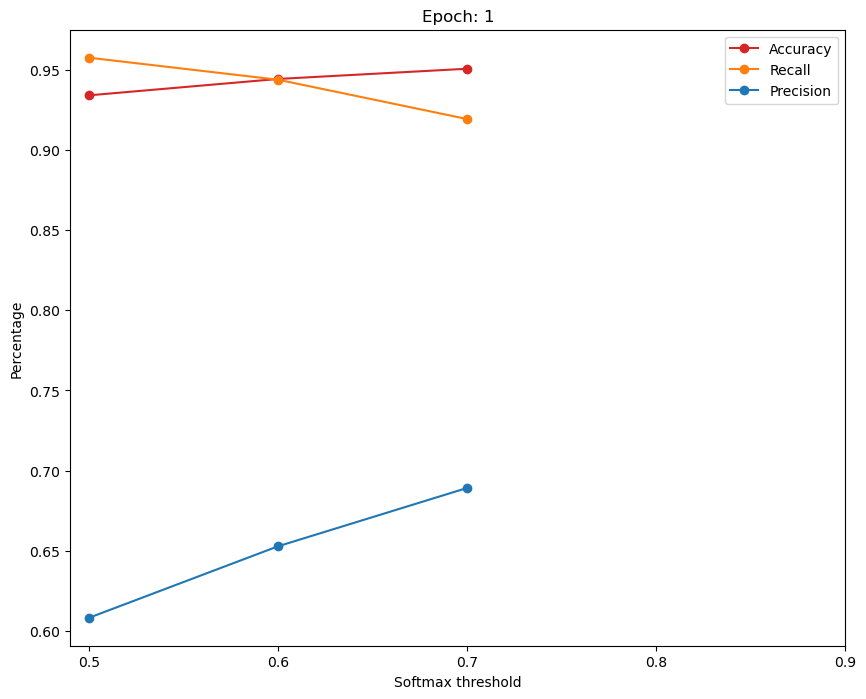

     Softmax Threshold [0.8]
         Image [500/2000], Accuracy: 95.79 %, Recall: 88.01 %, Precision: 74.56 %
         Image [1000/2000], Accuracy: 95.74 %, Recall: 87.48 %, Precision: 74.38 %
         Image [1500/2000], Accuracy: 95.71 %, Recall: 87.49 %, Precision: 74.28 %
         Image [2000/2000], Accuracy: 95.68 %, Recall: 87.49 %, Precision: 74.02 %


total:  64000 correct:  61233 true_pos_obj:  6402 correct_pos_pred:  5601 pos_pred:  7567
Accuracy of the network on the validation images: 95.67656249999999 % 
Recall of the network on the validation images: 87.48828491096532 % 
Precision of the network on the validation images: 74.01876569314128 % 


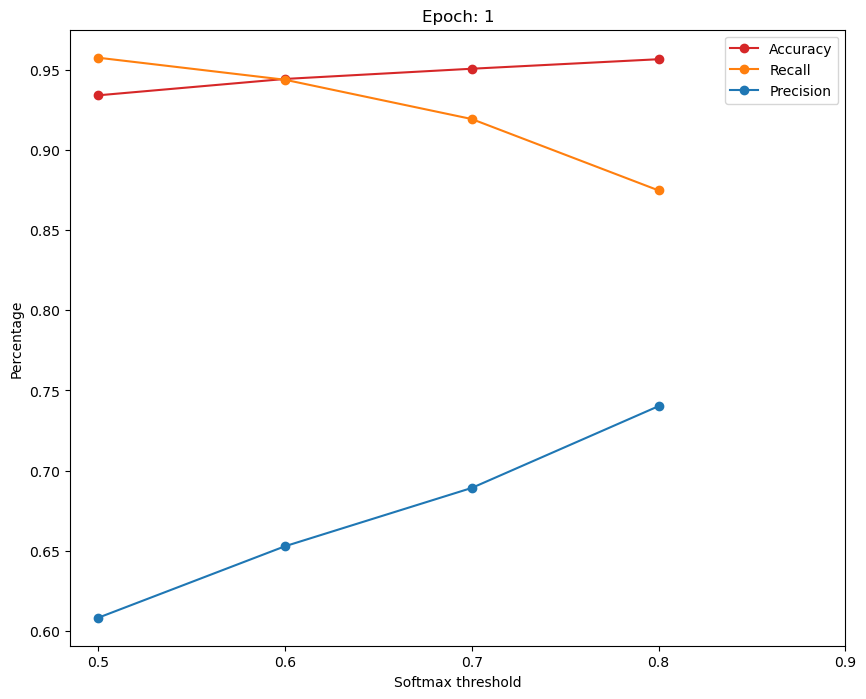

     Softmax Threshold [0.9]
         Image [500/2000], Accuracy: 95.78 %, Recall: 77.60 %, Precision: 78.36 %
         Image [1000/2000], Accuracy: 95.77 %, Recall: 76.78 %, Precision: 79.33 %
         Image [1500/2000], Accuracy: 95.82 %, Recall: 77.08 %, Precision: 79.99 %
         Image [2000/2000], Accuracy: 95.77 %, Recall: 76.58 %, Precision: 79.97 %


total:  64000 correct:  61291 true_pos_obj:  6359 correct_pos_pred:  4870 pos_pred:  6090
Accuracy of the network on the validation images: 95.76718749999999 % 
Recall of the network on the validation images: 76.58436861141689 % 
Precision of the network on the validation images: 79.96715927750411 % 


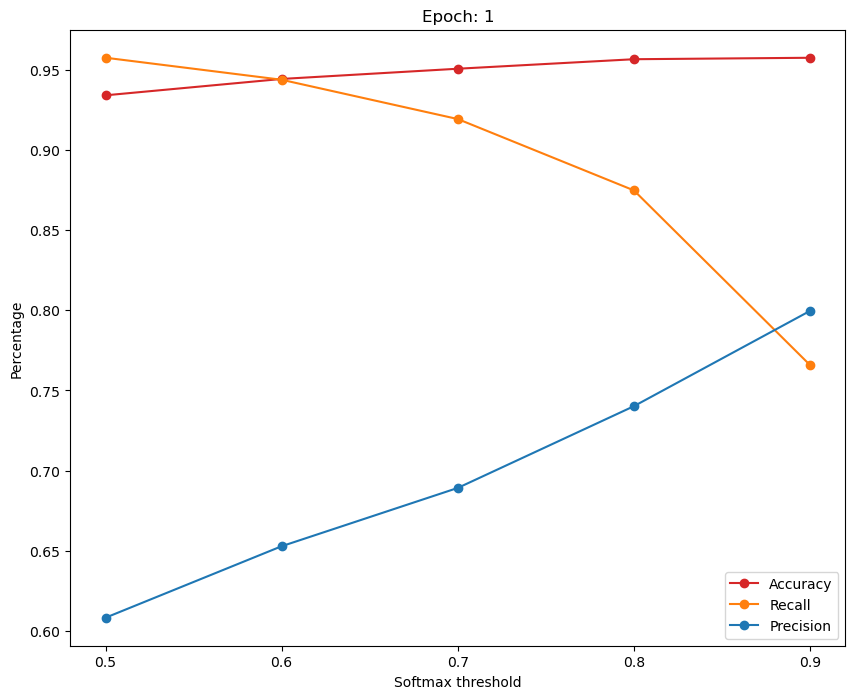

Epoch [2/10]
     Softmax Threshold [0.5]
         Image [500/2000], Accuracy: 93.61 %, Recall: 96.03 %, Precision: 61.38 %
         Image [1000/2000], Accuracy: 93.58 %, Recall: 96.31 %, Precision: 60.77 %
         Image [1500/2000], Accuracy: 93.42 %, Recall: 96.40 %, Precision: 60.52 %
         Image [2000/2000], Accuracy: 93.40 %, Recall: 96.47 %, Precision: 60.25 %


total:  64000 correct:  59776 true_pos_obj:  6287 correct_pos_pred:  6065 pos_pred:  10067
Accuracy of the network on the validation images: 93.4 % 
Recall of the network on the validation images: 96.46890408780023 % 
Precision of the network on the validation images: 60.2463494586272 % 


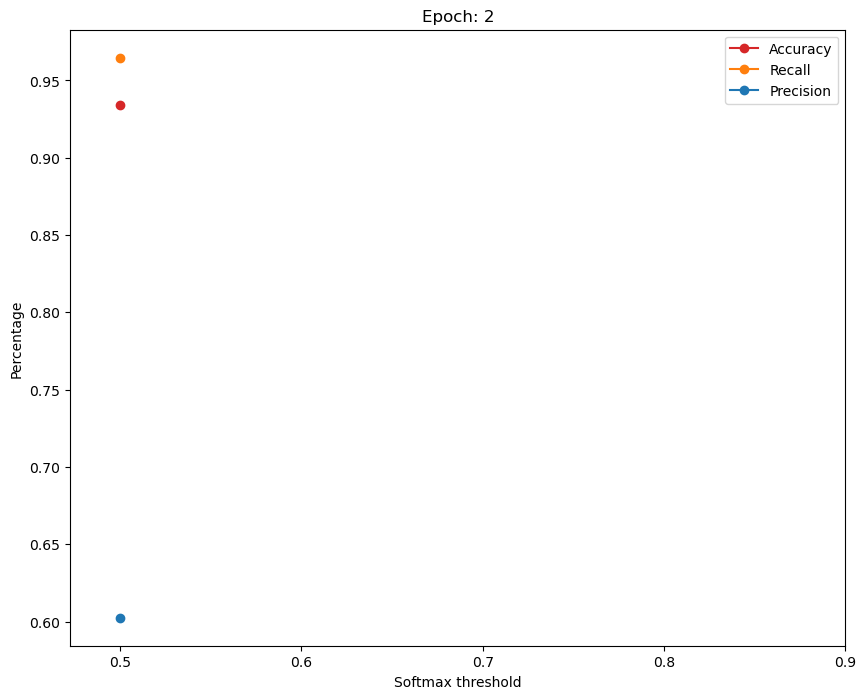

     Softmax Threshold [0.6]
         Image [500/2000], Accuracy: 94.56 %, Recall: 94.62 %, Precision: 65.85 %
         Image [1000/2000], Accuracy: 94.39 %, Recall: 95.09 %, Precision: 65.32 %
         Image [1500/2000], Accuracy: 94.38 %, Recall: 95.21 %, Precision: 65.25 %
         Image [2000/2000], Accuracy: 94.34 %, Recall: 95.01 %, Precision: 65.32 %


total:  64000 correct:  60380 true_pos_obj:  6530 correct_pos_pred:  6204 pos_pred:  9498
Accuracy of the network on the validation images: 94.34375 % 
Recall of the network on the validation images: 95.00765696784073 % 
Precision of the network on the validation images: 65.31901452937461 % 


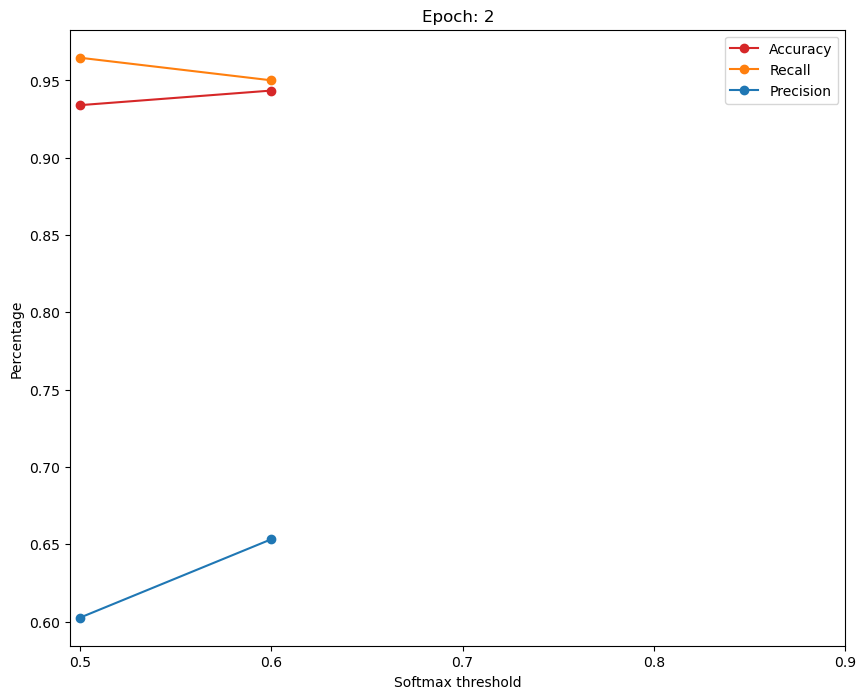

     Softmax Threshold [0.7]
         Image [500/2000], Accuracy: 94.96 %, Recall: 92.77 %, Precision: 68.30 %
         Image [1000/2000], Accuracy: 95.20 %, Recall: 93.16 %, Precision: 69.84 %
         Image [1500/2000], Accuracy: 95.14 %, Recall: 93.53 %, Precision: 69.30 %
         Image [2000/2000], Accuracy: 95.11 %, Recall: 93.56 %, Precision: 69.03 %


total:  64000 correct:  60871 true_pos_obj:  6464 correct_pos_pred:  6048 pos_pred:  8761
Accuracy of the network on the validation images: 95.1109375 % 
Recall of the network on the validation images: 93.56435643564357 % 
Precision of the network on the validation images: 69.03321538637141 % 


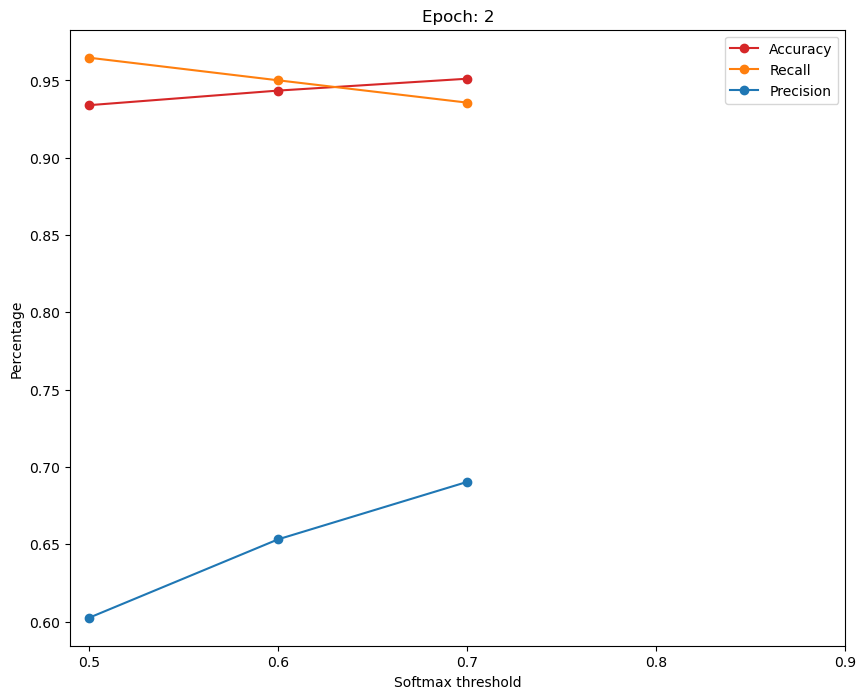

     Softmax Threshold [0.8]
         Image [500/2000], Accuracy: 95.67 %, Recall: 88.51 %, Precision: 74.14 %
         Image [1000/2000], Accuracy: 95.65 %, Recall: 89.13 %, Precision: 73.65 %
         Image [1500/2000], Accuracy: 95.70 %, Recall: 89.77 %, Precision: 73.35 %
         Image [2000/2000], Accuracy: 95.78 %, Recall: 89.63 %, Precision: 74.11 %


total:  64000 correct:  61299 true_pos_obj:  6480 correct_pos_pred:  5808 pos_pred:  7837
Accuracy of the network on the validation images: 95.7796875 % 
Recall of the network on the validation images: 89.62962962962962 % 
Precision of the network on the validation images: 74.10999106801071 % 


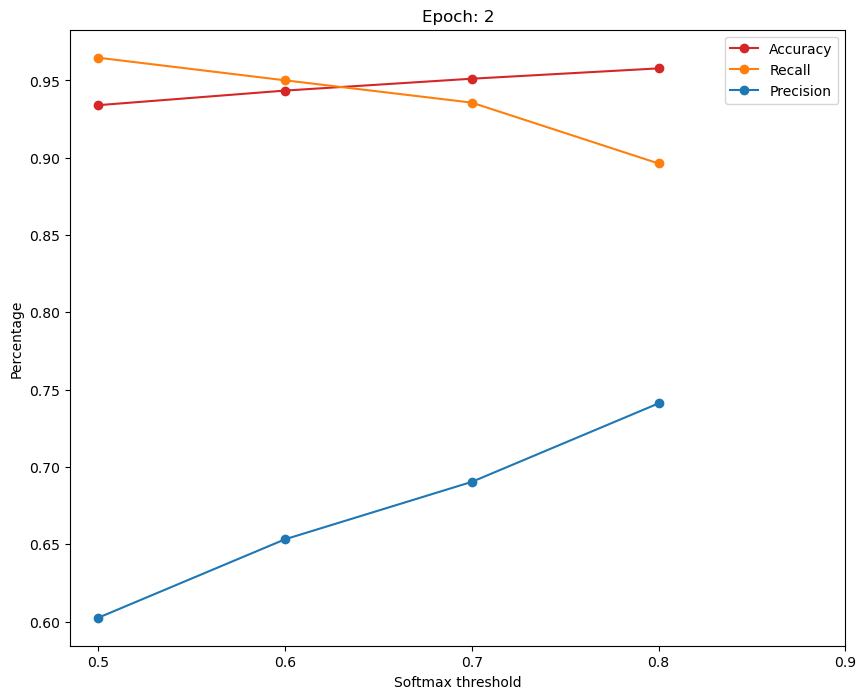

     Softmax Threshold [0.9]
         Image [500/2000], Accuracy: 96.33 %, Recall: 81.54 %, Precision: 80.97 %
         Image [1000/2000], Accuracy: 96.23 %, Recall: 80.75 %, Precision: 81.43 %
         Image [1500/2000], Accuracy: 96.17 %, Recall: 80.36 %, Precision: 81.27 %
         Image [2000/2000], Accuracy: 96.14 %, Recall: 80.39 %, Precision: 81.30 %


total:  64000 correct:  61531 true_pos_obj:  6481 correct_pos_pred:  5210 pos_pred:  6408
Accuracy of the network on the validation images: 96.14218749999999 % 
Recall of the network on the validation images: 80.38882888443142 % 
Precision of the network on the validation images: 81.30461922596754 % 


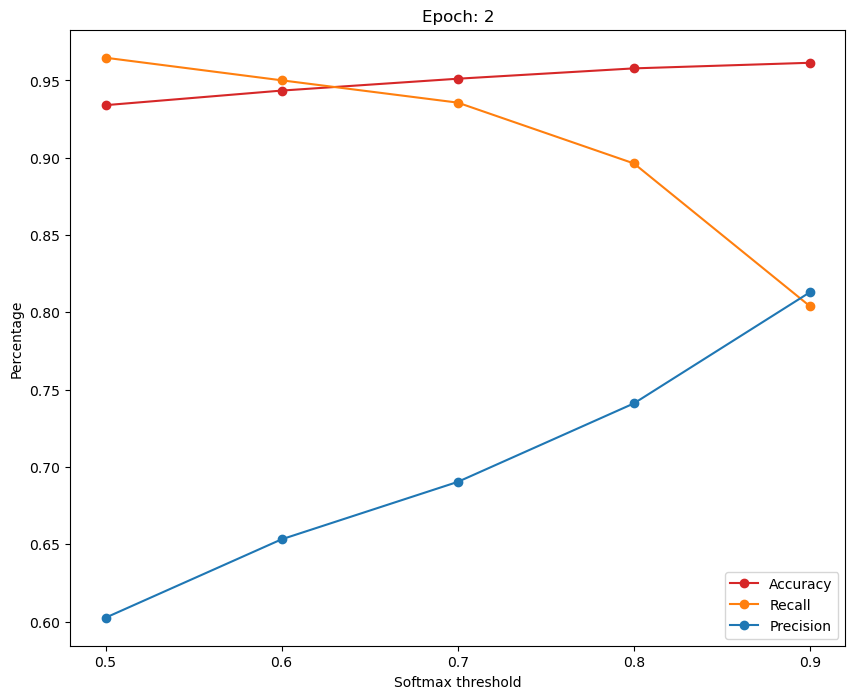

Epoch [3/10]
     Softmax Threshold [0.5]
         Image [500/2000], Accuracy: 94.56 %, Recall: 94.27 %, Precision: 66.01 %
         Image [1000/2000], Accuracy: 94.37 %, Recall: 93.91 %, Precision: 64.61 %
         Image [1500/2000], Accuracy: 94.28 %, Recall: 94.27 %, Precision: 64.02 %
         Image [2000/2000], Accuracy: 94.31 %, Recall: 94.40 %, Precision: 64.31 %


total:  64000 correct:  60356 true_pos_obj:  6285 correct_pos_pred:  5933 pos_pred:  9225
Accuracy of the network on the validation images: 94.30625 % 
Recall of the network on the validation images: 94.39936356404137 % 
Precision of the network on the validation images: 64.31436314363144 % 


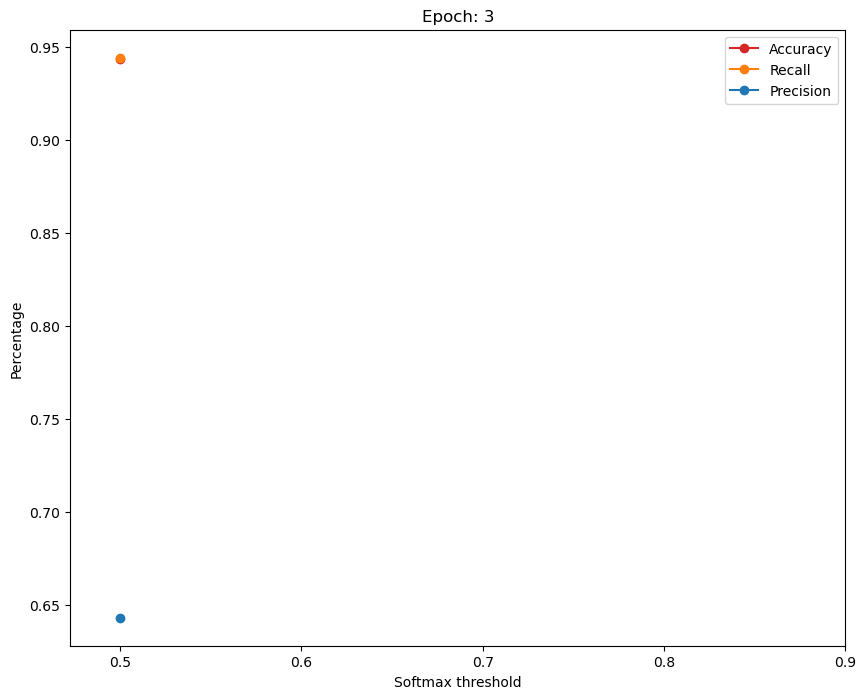

     Softmax Threshold [0.6]
         Image [500/2000], Accuracy: 95.01 %, Recall: 92.94 %, Precision: 68.26 %
         Image [1000/2000], Accuracy: 94.97 %, Recall: 92.86 %, Precision: 68.54 %
         Image [1500/2000], Accuracy: 94.91 %, Recall: 92.73 %, Precision: 68.04 %
         Image [2000/2000], Accuracy: 94.84 %, Recall: 92.85 %, Precision: 67.53 %


total:  64000 correct:  60697 true_pos_obj:  6376 correct_pos_pred:  5920 pos_pred:  8767
Accuracy of the network on the validation images: 94.83906250000001 % 
Recall of the network on the validation images: 92.84818067754078 % 
Precision of the network on the validation images: 67.52594958366602 % 


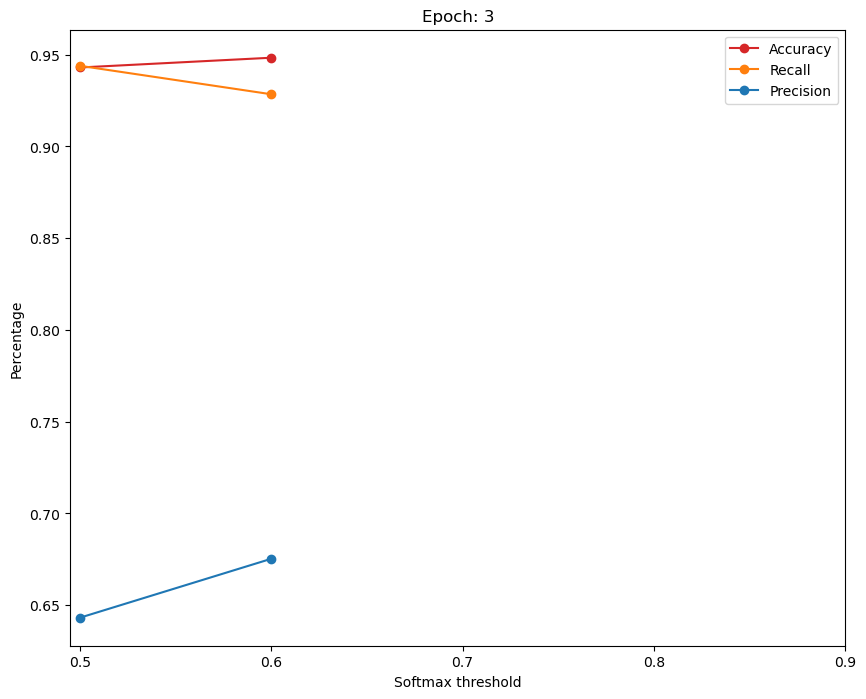

     Softmax Threshold [0.7]
         Image [500/2000], Accuracy: 95.83 %, Recall: 91.79 %, Precision: 73.58 %
         Image [1000/2000], Accuracy: 95.69 %, Recall: 91.59 %, Precision: 72.62 %
         Image [1500/2000], Accuracy: 95.68 %, Recall: 91.38 %, Precision: 72.55 %
         Image [2000/2000], Accuracy: 95.69 %, Recall: 91.41 %, Precision: 72.65 %


total:  64000 correct:  61242 true_pos_obj:  6413 correct_pos_pred:  5862 pos_pred:  8069
Accuracy of the network on the validation images: 95.690625 % 
Recall of the network on the validation images: 91.40807734289724 % 
Precision of the network on the validation images: 72.6484074854381 % 


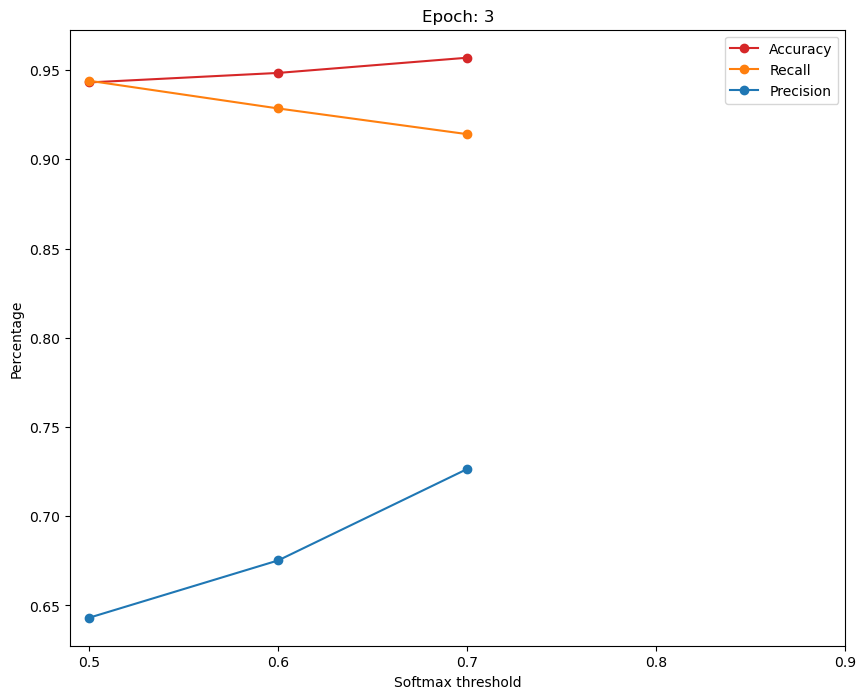

     Softmax Threshold [0.8]
         Image [500/2000], Accuracy: 95.83 %, Recall: 88.11 %, Precision: 75.20 %
         Image [1000/2000], Accuracy: 95.88 %, Recall: 87.92 %, Precision: 75.23 %
         Image [1500/2000], Accuracy: 95.89 %, Recall: 87.58 %, Precision: 75.18 %
         Image [2000/2000], Accuracy: 95.90 %, Recall: 87.69 %, Precision: 75.14 %


total:  64000 correct:  61378 true_pos_obj:  6346 correct_pos_pred:  5565 pos_pred:  7406
Accuracy of the network on the validation images: 95.903125 % 
Recall of the network on the validation images: 87.69303498266625 % 
Precision of the network on the validation images: 75.14177693761815 % 


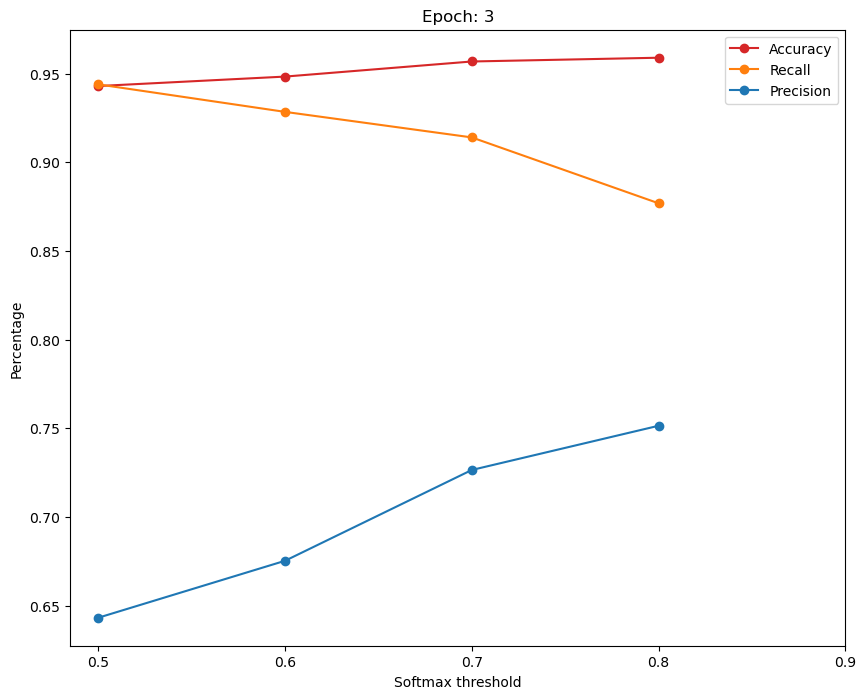

     Softmax Threshold [0.9]
         Image [500/2000], Accuracy: 96.28 %, Recall: 78.93 %, Precision: 82.10 %
         Image [1000/2000], Accuracy: 96.18 %, Recall: 78.68 %, Precision: 81.92 %
         Image [1500/2000], Accuracy: 96.14 %, Recall: 78.37 %, Precision: 81.65 %
         Image [2000/2000], Accuracy: 96.11 %, Recall: 77.89 %, Precision: 82.08 %


total:  64000 correct:  61511 true_pos_obj:  6364 correct_pos_pred:  4957 pos_pred:  6039
Accuracy of the network on the validation images: 96.1109375 % 
Recall of the network on the validation images: 77.89126335637964 % 
Precision of the network on the validation images: 82.08312634542143 % 


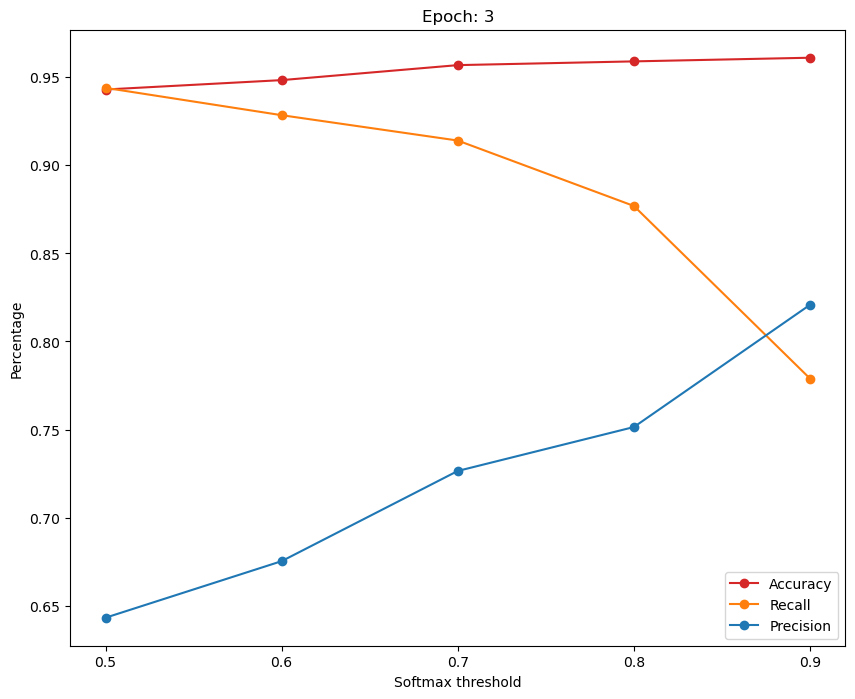

Epoch [4/10]
     Softmax Threshold [0.5]
         Image [500/2000], Accuracy: 94.16 %, Recall: 96.42 %, Precision: 63.63 %
         Image [1000/2000], Accuracy: 94.30 %, Recall: 95.89 %, Precision: 64.17 %
         Image [1500/2000], Accuracy: 94.31 %, Recall: 95.86 %, Precision: 64.31 %
         Image [2000/2000], Accuracy: 94.29 %, Recall: 95.85 %, Precision: 64.13 %


total:  64000 correct:  60343 true_pos_obj:  6332 correct_pos_pred:  6069 pos_pred:  9463
Accuracy of the network on the validation images: 94.2859375 % 
Recall of the network on the validation images: 95.84649399873658 % 
Precision of the network on the validation images: 64.13399556166121 % 


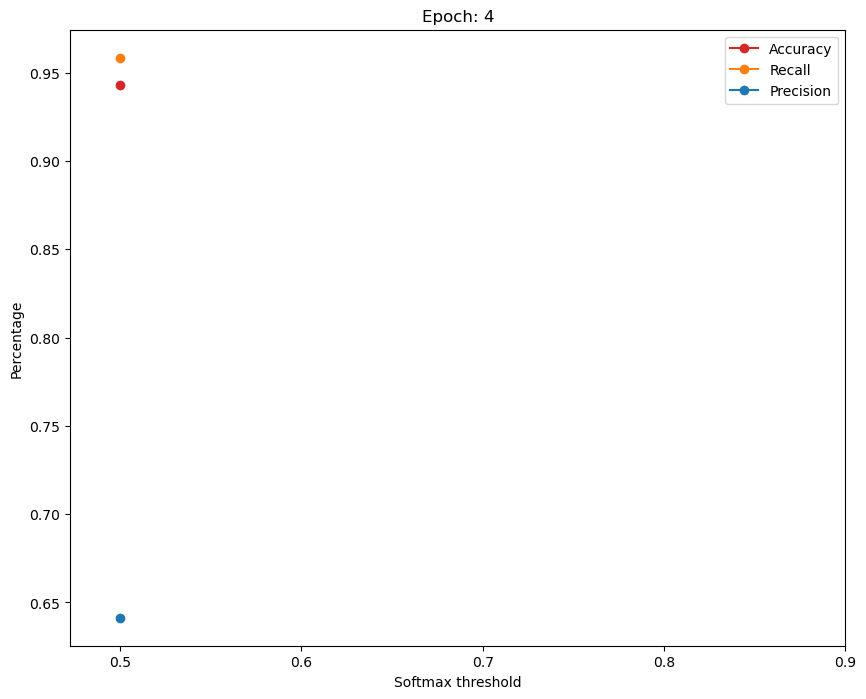

     Softmax Threshold [0.6]
         Image [500/2000], Accuracy: 94.61 %, Recall: 94.39 %, Precision: 65.63 %
         Image [1000/2000], Accuracy: 94.58 %, Recall: 94.79 %, Precision: 65.67 %
         Image [1500/2000], Accuracy: 94.58 %, Recall: 94.76 %, Precision: 65.67 %
         Image [2000/2000], Accuracy: 94.57 %, Recall: 94.89 %, Precision: 65.71 %


total:  64000 correct:  60526 true_pos_obj:  6360 correct_pos_pred:  6035 pos_pred:  9184
Accuracy of the network on the validation images: 94.571875 % 
Recall of the network on the validation images: 94.88993710691824 % 
Precision of the network on the validation images: 65.71210801393728 % 


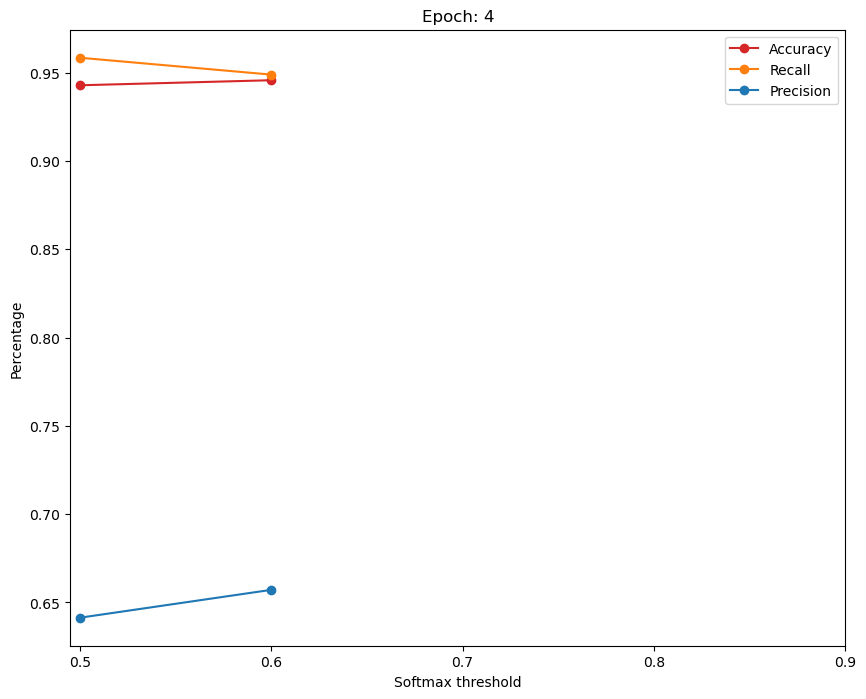

     Softmax Threshold [0.7]
         Image [500/2000], Accuracy: 95.62 %, Recall: 92.76 %, Precision: 71.32 %
         Image [1000/2000], Accuracy: 95.44 %, Recall: 92.64 %, Precision: 70.51 %
         Image [1500/2000], Accuracy: 95.48 %, Recall: 93.11 %, Precision: 70.58 %
         Image [2000/2000], Accuracy: 95.37 %, Recall: 92.89 %, Precision: 70.31 %


total:  64000 correct:  61035 true_pos_obj:  6398 correct_pos_pred:  5943 pos_pred:  8453
Accuracy of the network on the validation images: 95.3671875 % 
Recall of the network on the validation images: 92.88840262582056 % 
Precision of the network on the validation images: 70.30640009464095 % 


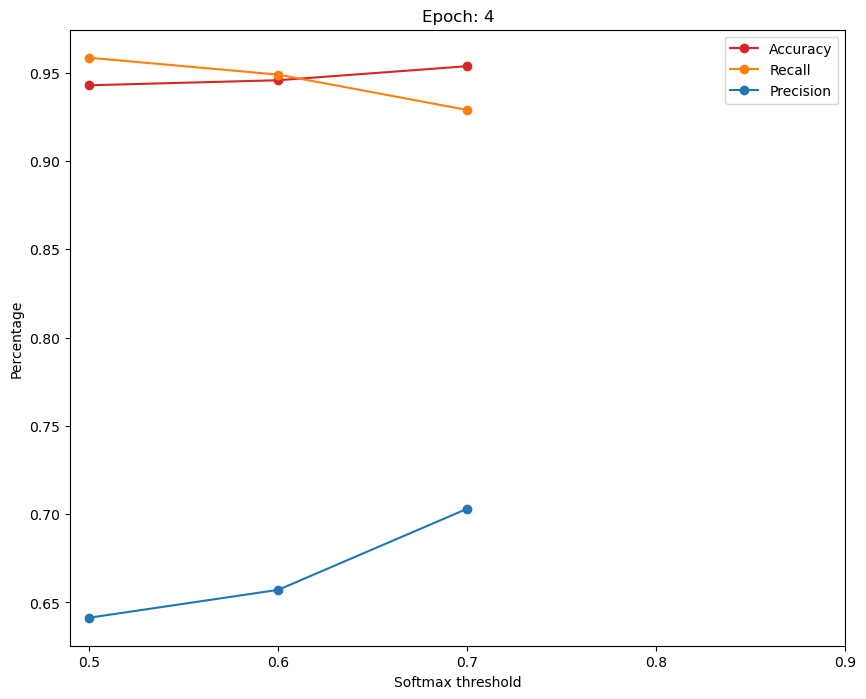

     Softmax Threshold [0.8]
         Image [500/2000], Accuracy: 96.08 %, Recall: 89.51 %, Precision: 76.19 %
         Image [1000/2000], Accuracy: 96.04 %, Recall: 89.68 %, Precision: 75.95 %
         Image [1500/2000], Accuracy: 96.07 %, Recall: 89.64 %, Precision: 76.17 %
         Image [2000/2000], Accuracy: 96.01 %, Recall: 89.72 %, Precision: 75.32 %


total:  64000 correct:  61448 true_pos_obj:  6433 correct_pos_pred:  5772 pos_pred:  7663
Accuracy of the network on the validation images: 96.0125 % 
Recall of the network on the validation images: 89.72485621016632 % 
Precision of the network on the validation images: 75.32298055591805 % 


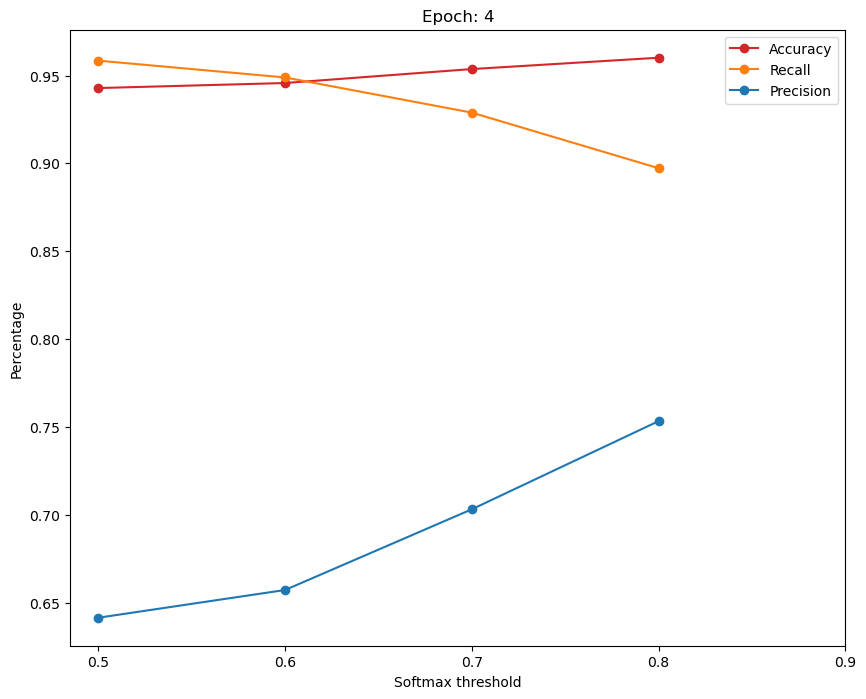

     Softmax Threshold [0.9]
         Image [500/2000], Accuracy: 96.16 %, Recall: 79.59 %, Precision: 81.43 %
         Image [1000/2000], Accuracy: 96.21 %, Recall: 79.04 %, Precision: 82.48 %
         Image [1500/2000], Accuracy: 96.14 %, Recall: 78.61 %, Precision: 82.37 %
         Image [2000/2000], Accuracy: 96.19 %, Recall: 78.81 %, Precision: 82.36 %


total:  64000 correct:  61559 true_pos_obj:  6412 correct_pos_pred:  5053 pos_pred:  6135
Accuracy of the network on the validation images: 96.1859375 % 
Recall of the network on the validation images: 78.80536494073613 % 
Precision of the network on the validation images: 82.36348818255908 % 


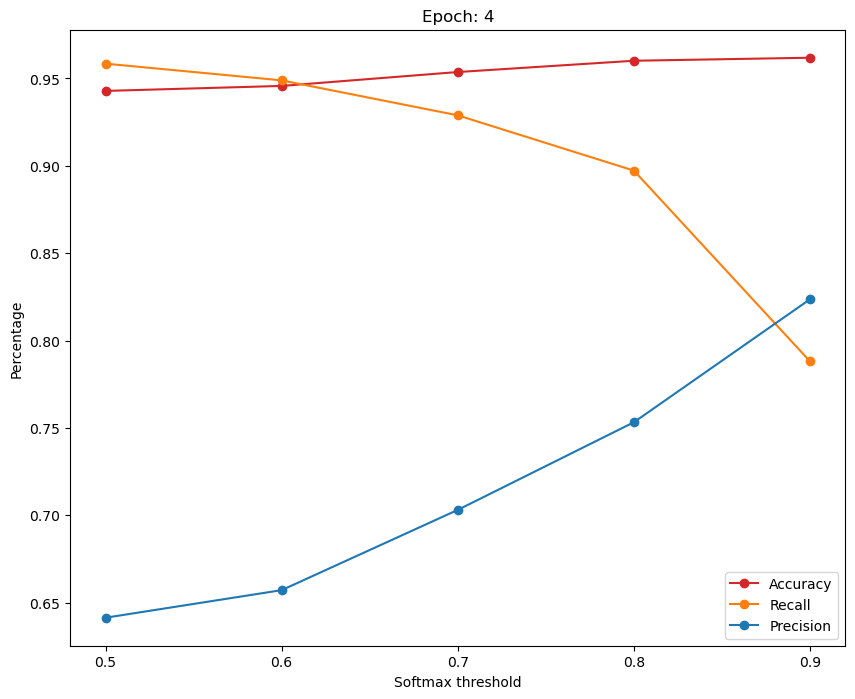

Epoch [5/10]
     Softmax Threshold [0.5]
         Image [500/2000], Accuracy: 94.31 %, Recall: 97.14 %, Precision: 64.39 %
         Image [1000/2000], Accuracy: 94.25 %, Recall: 97.28 %, Precision: 64.29 %
         Image [1500/2000], Accuracy: 94.34 %, Recall: 97.11 %, Precision: 64.63 %
         Image [2000/2000], Accuracy: 94.29 %, Recall: 97.09 %, Precision: 64.28 %


total:  64000 correct:  60345 true_pos_obj:  6429 correct_pos_pred:  6242 pos_pred:  9710
Accuracy of the network on the validation images: 94.2890625 % 
Recall of the network on the validation images: 97.0913050241095 % 
Precision of the network on the validation images: 64.28424304840371 % 


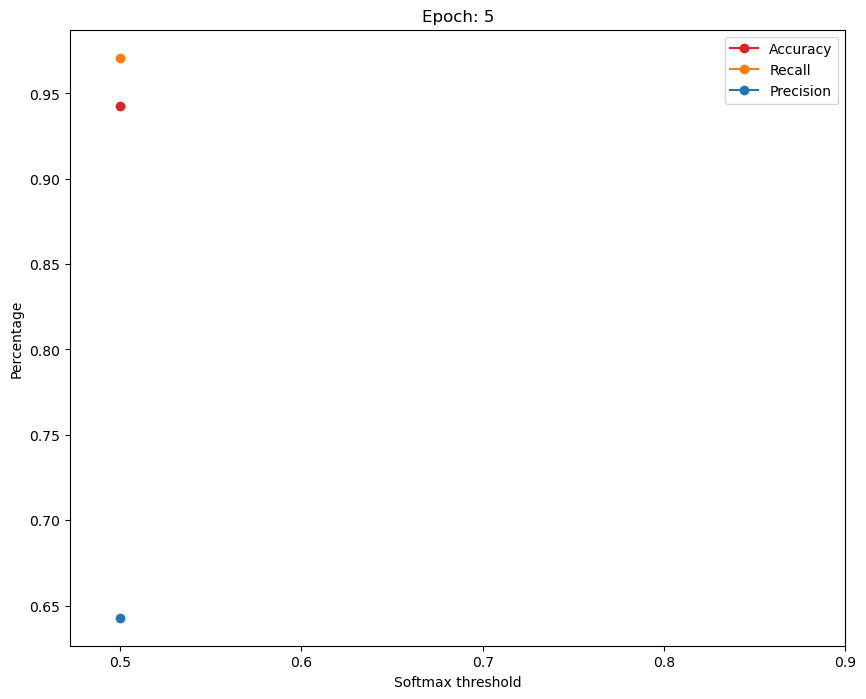

     Softmax Threshold [0.6]
         Image [500/2000], Accuracy: 94.74 %, Recall: 95.91 %, Precision: 65.86 %
         Image [1000/2000], Accuracy: 94.84 %, Recall: 95.92 %, Precision: 66.76 %
         Image [1500/2000], Accuracy: 94.73 %, Recall: 95.86 %, Precision: 65.80 %
         Image [2000/2000], Accuracy: 94.59 %, Recall: 95.62 %, Precision: 65.42 %


total:  64000 correct:  60540 true_pos_obj:  6299 correct_pos_pred:  6023 pos_pred:  9207
Accuracy of the network on the validation images: 94.59375 % 
Recall of the network on the validation images: 95.61835211938403 % 
Precision of the network on the validation images: 65.41761703052026 % 


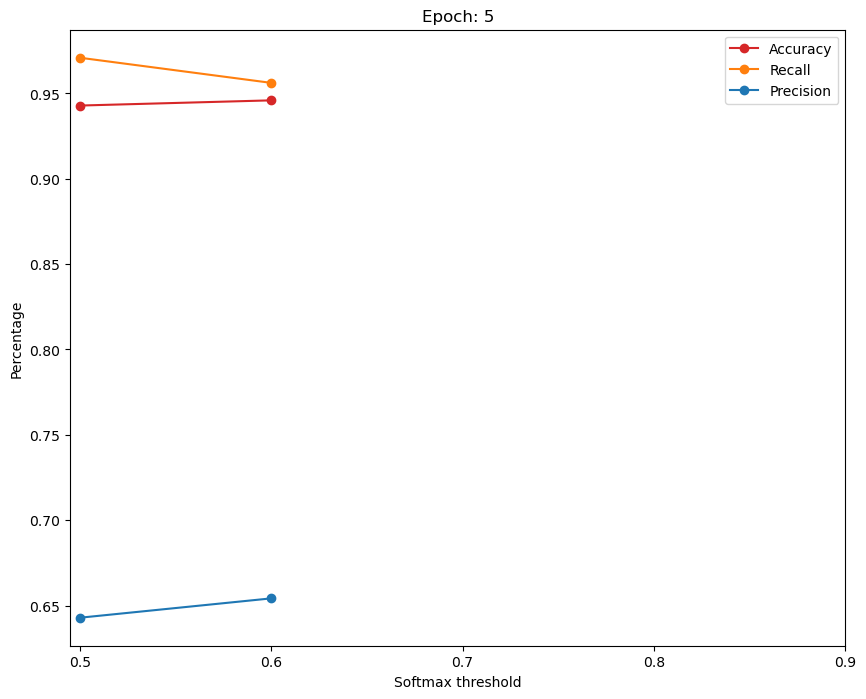

     Softmax Threshold [0.7]
         Image [500/2000], Accuracy: 95.25 %, Recall: 95.91 %, Precision: 69.05 %
         Image [1000/2000], Accuracy: 95.17 %, Recall: 95.22 %, Precision: 68.94 %
         Image [1500/2000], Accuracy: 95.20 %, Recall: 95.14 %, Precision: 68.97 %
         Image [2000/2000], Accuracy: 95.21 %, Recall: 95.04 %, Precision: 68.82 %


total:  64000 correct:  60934 true_pos_obj:  6385 correct_pos_pred:  6068 pos_pred:  8817
Accuracy of the network on the validation images: 95.209375 % 
Recall of the network on the validation images: 95.03523884103367 % 
Precision of the network on the validation images: 68.82159464670524 % 


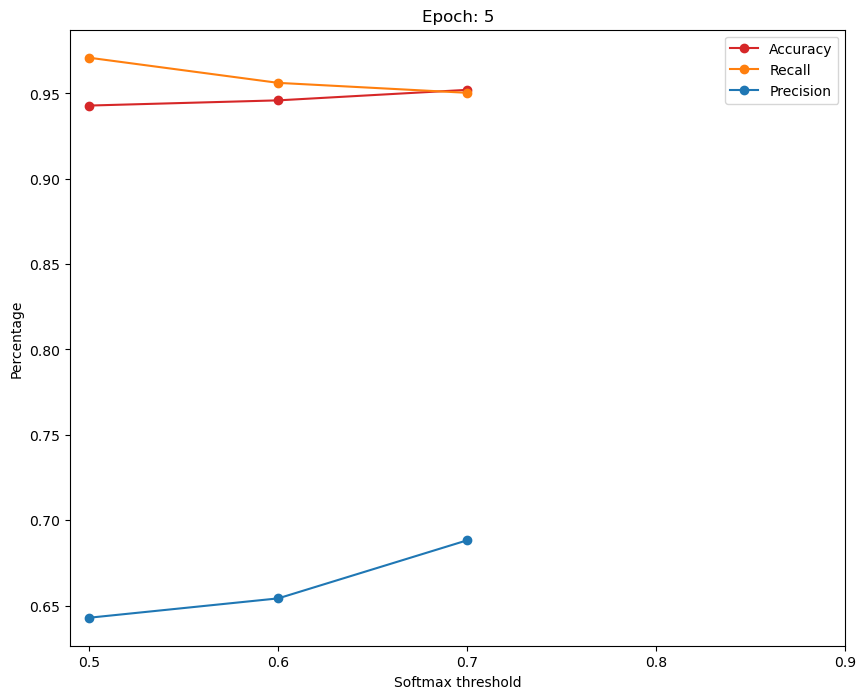

     Softmax Threshold [0.8]
         Image [500/2000], Accuracy: 95.78 %, Recall: 94.11 %, Precision: 72.60 %
         Image [1000/2000], Accuracy: 95.70 %, Recall: 93.43 %, Precision: 72.71 %
         Image [1500/2000], Accuracy: 95.68 %, Recall: 93.40 %, Precision: 72.30 %
         Image [2000/2000], Accuracy: 95.70 %, Recall: 93.37 %, Precision: 72.10 %


total:  64000 correct:  61248 true_pos_obj:  6436 correct_pos_pred:  6009 pos_pred:  8334
Accuracy of the network on the validation images: 95.7 % 
Recall of the network on the validation images: 93.36544437538844 % 
Precision of the network on the validation images: 72.10223182145428 % 


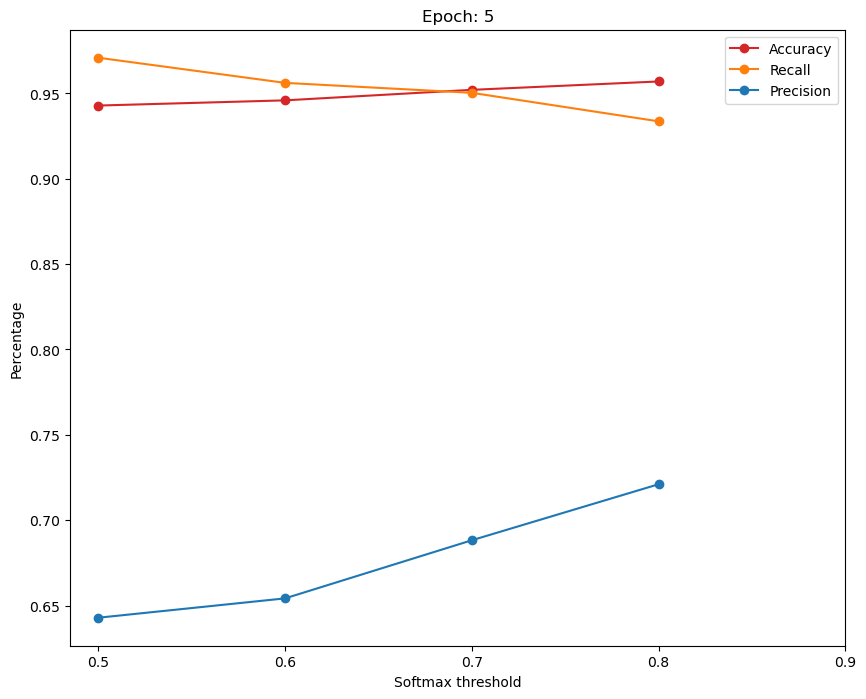

     Softmax Threshold [0.9]
         Image [500/2000], Accuracy: 96.26 %, Recall: 88.64 %, Precision: 77.84 %
         Image [1000/2000], Accuracy: 96.17 %, Recall: 88.98 %, Precision: 76.71 %
         Image [1500/2000], Accuracy: 96.24 %, Recall: 88.92 %, Precision: 77.29 %
         Image [2000/2000], Accuracy: 96.31 %, Recall: 89.11 %, Precision: 77.68 %


total:  64000 correct:  61638 true_pos_obj:  6473 correct_pos_pred:  5768 pos_pred:  7425
Accuracy of the network on the validation images: 96.309375 % 
Recall of the network on the validation images: 89.1086049745095 % 
Precision of the network on the validation images: 77.68350168350169 % 


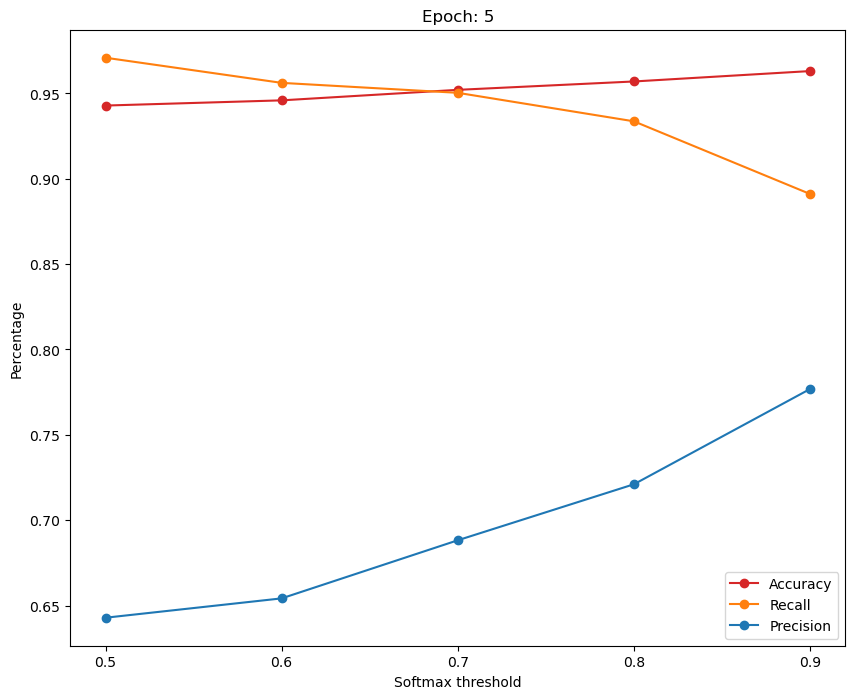

Epoch [6/10]
     Softmax Threshold [0.5]
         Image [500/2000], Accuracy: 95.07 %, Recall: 94.97 %, Precision: 68.63 %
         Image [1000/2000], Accuracy: 95.19 %, Recall: 94.99 %, Precision: 68.88 %
         Image [1500/2000], Accuracy: 95.17 %, Recall: 94.81 %, Precision: 68.83 %
         Image [2000/2000], Accuracy: 95.14 %, Recall: 94.70 %, Precision: 68.74 %


total:  64000 correct:  60889 true_pos_obj:  6431 correct_pos_pred:  6090 pos_pred:  8860
Accuracy of the network on the validation images: 95.13906250000001 % 
Recall of the network on the validation images: 94.69755870004664 % 
Precision of the network on the validation images: 68.73589164785552 % 


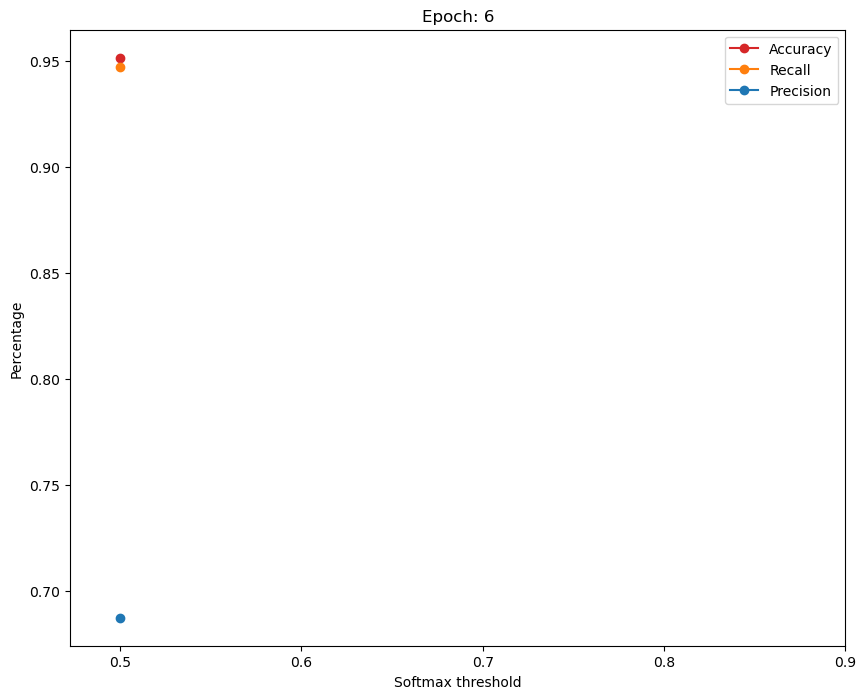

     Softmax Threshold [0.6]
         Image [500/2000], Accuracy: 95.84 %, Recall: 93.99 %, Precision: 72.74 %
         Image [1000/2000], Accuracy: 95.66 %, Recall: 94.36 %, Precision: 71.74 %
         Image [1500/2000], Accuracy: 95.55 %, Recall: 94.10 %, Precision: 71.20 %
         Image [2000/2000], Accuracy: 95.52 %, Recall: 94.05 %, Precision: 71.03 %


total:  64000 correct:  61132 true_pos_obj:  6472 correct_pos_pred:  6087 pos_pred:  8570
Accuracy of the network on the validation images: 95.51875 % 
Recall of the network on the validation images: 94.0512978986403 % 
Precision of the network on the validation images: 71.02683780630105 % 


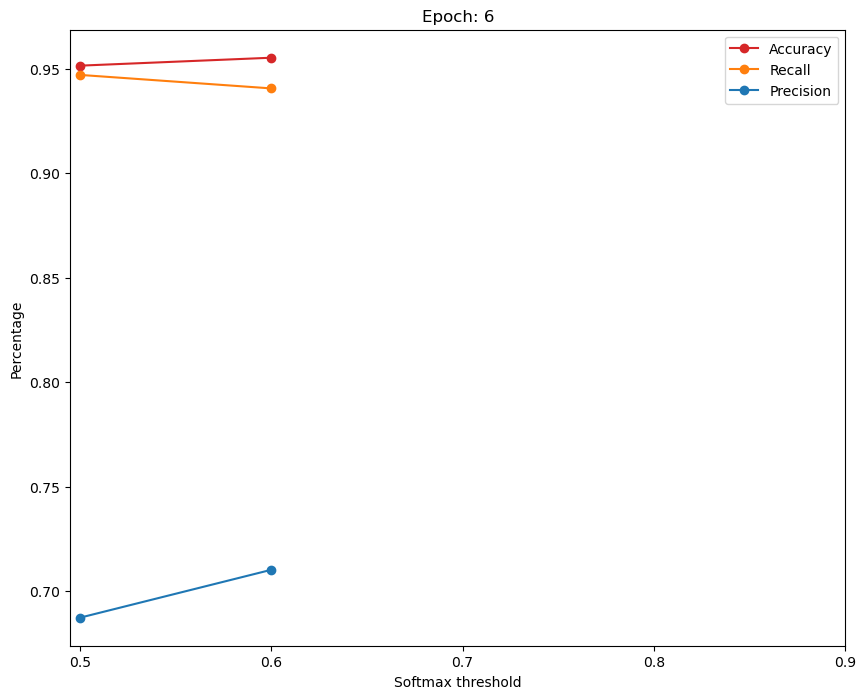

     Softmax Threshold [0.7]
         Image [500/2000], Accuracy: 95.89 %, Recall: 93.14 %, Precision: 72.53 %
         Image [1000/2000], Accuracy: 95.85 %, Recall: 92.45 %, Precision: 72.99 %
         Image [1500/2000], Accuracy: 95.95 %, Recall: 92.67 %, Precision: 73.34 %
         Image [2000/2000], Accuracy: 95.97 %, Recall: 92.57 %, Precision: 73.69 %


total:  64000 correct:  61424 true_pos_obj:  6363 correct_pos_pred:  5890 pos_pred:  7993
Accuracy of the network on the validation images: 95.975 % 
Recall of the network on the validation images: 92.56639949709256 % 
Precision of the network on the validation images: 73.68947829350681 % 


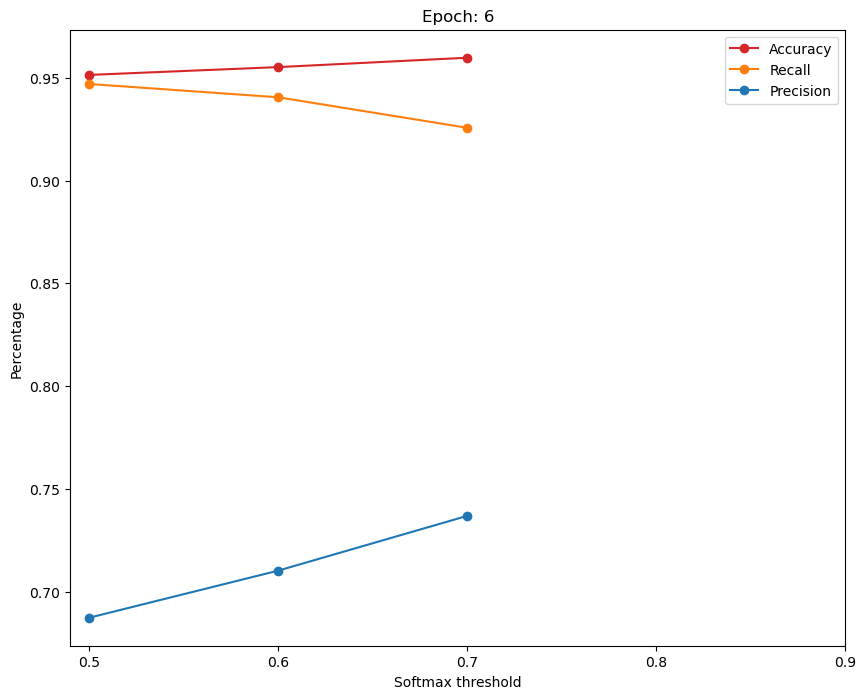

     Softmax Threshold [0.8]
         Image [500/2000], Accuracy: 96.18 %, Recall: 89.37 %, Precision: 77.42 %
         Image [1000/2000], Accuracy: 96.24 %, Recall: 90.35 %, Precision: 77.23 %
         Image [1500/2000], Accuracy: 96.24 %, Recall: 90.27 %, Precision: 76.84 %
         Image [2000/2000], Accuracy: 96.22 %, Recall: 90.10 %, Precision: 76.65 %


total:  64000 correct:  61582 true_pos_obj:  6475 correct_pos_pred:  5834 pos_pred:  7611
Accuracy of the network on the validation images: 96.221875 % 
Recall of the network on the validation images: 90.1003861003861 % 
Precision of the network on the validation images: 76.65221390093286 % 


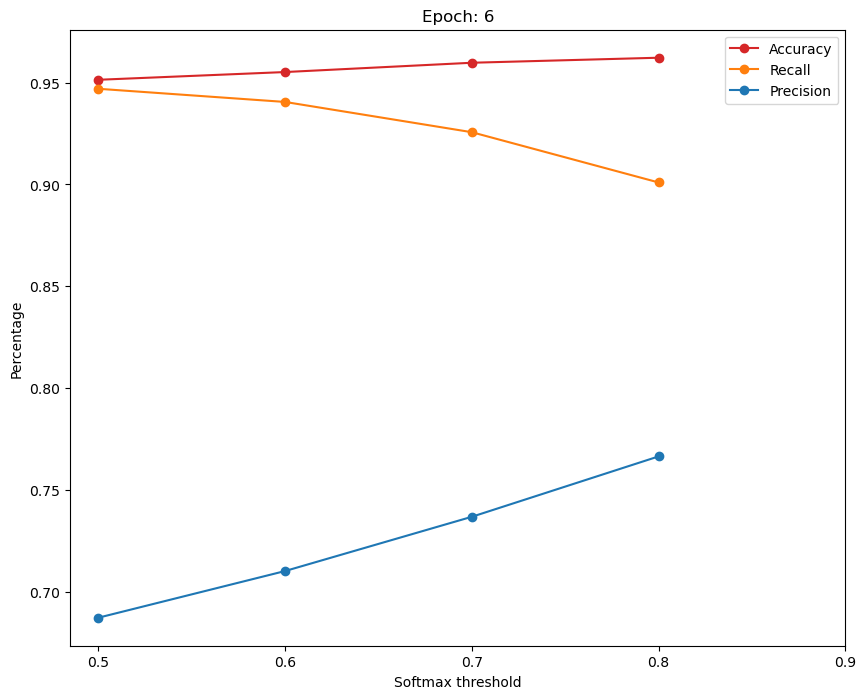

     Softmax Threshold [0.9]
         Image [500/2000], Accuracy: 96.14 %, Recall: 82.41 %, Precision: 79.29 %
         Image [1000/2000], Accuracy: 96.39 %, Recall: 83.71 %, Precision: 80.69 %
         Image [1500/2000], Accuracy: 96.39 %, Recall: 83.57 %, Precision: 80.79 %
         Image [2000/2000], Accuracy: 96.36 %, Recall: 83.83 %, Precision: 80.50 %


total:  64000 correct:  61668 true_pos_obj:  6393 correct_pos_pred:  5359 pos_pred:  6657
Accuracy of the network on the validation images: 96.35625 % 
Recall of the network on the validation images: 83.82605975285469 % 
Precision of the network on the validation images: 80.50172750488208 % 


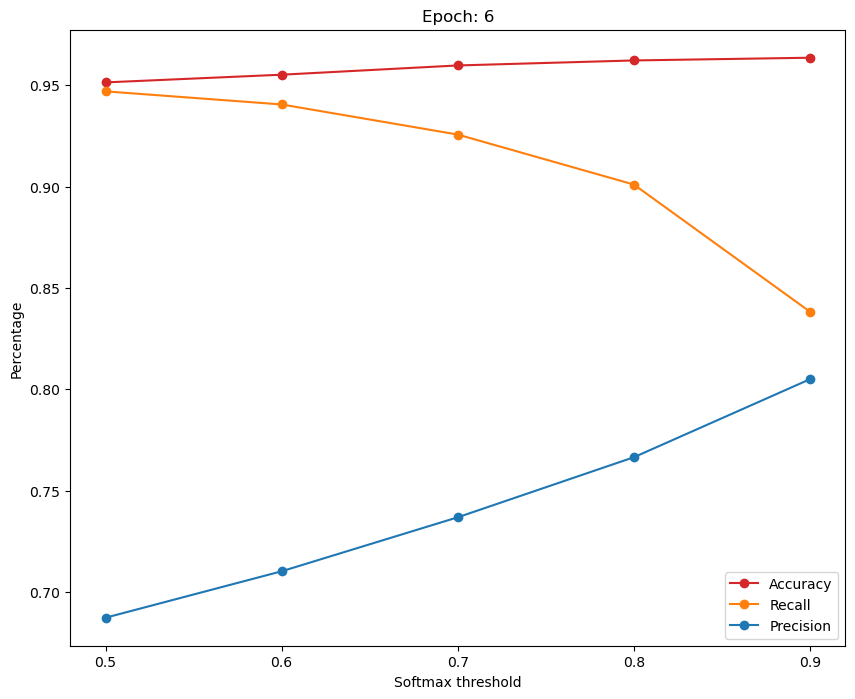

Epoch [7/10]
     Softmax Threshold [0.5]
         Image [500/2000], Accuracy: 95.25 %, Recall: 94.21 %, Precision: 68.60 %
         Image [1000/2000], Accuracy: 95.21 %, Recall: 93.97 %, Precision: 68.40 %
         Image [1500/2000], Accuracy: 95.20 %, Recall: 94.13 %, Precision: 68.83 %
         Image [2000/2000], Accuracy: 95.16 %, Recall: 94.17 %, Precision: 68.80 %


total:  64000 correct:  60904 true_pos_obj:  6378 correct_pos_pred:  6006 pos_pred:  8730
Accuracy of the network on the validation images: 95.16250000000001 % 
Recall of the network on the validation images: 94.16745061147695 % 
Precision of the network on the validation images: 68.79725085910653 % 


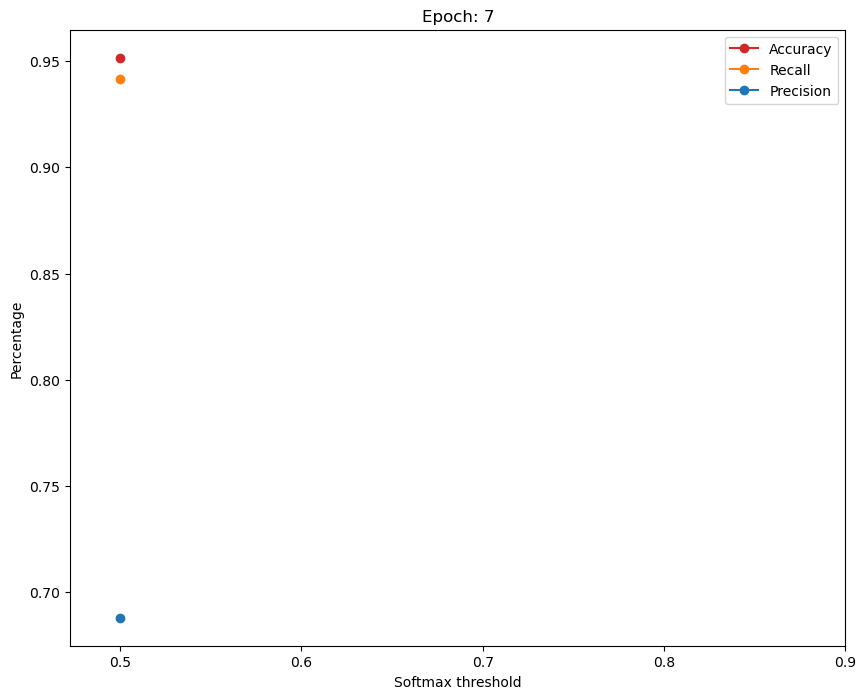

     Softmax Threshold [0.6]
         Image [500/2000], Accuracy: 95.69 %, Recall: 95.23 %, Precision: 70.90 %
         Image [1000/2000], Accuracy: 95.51 %, Recall: 94.26 %, Precision: 70.05 %
         Image [1500/2000], Accuracy: 95.52 %, Recall: 93.83 %, Precision: 70.18 %
         Image [2000/2000], Accuracy: 95.39 %, Recall: 93.56 %, Precision: 69.79 %


total:  64000 correct:  61049 true_pos_obj:  6286 correct_pos_pred:  5881 pos_pred:  8427
Accuracy of the network on the validation images: 95.3890625 % 
Recall of the network on the validation images: 93.55711104040726 % 
Precision of the network on the validation images: 69.78758751631659 % 


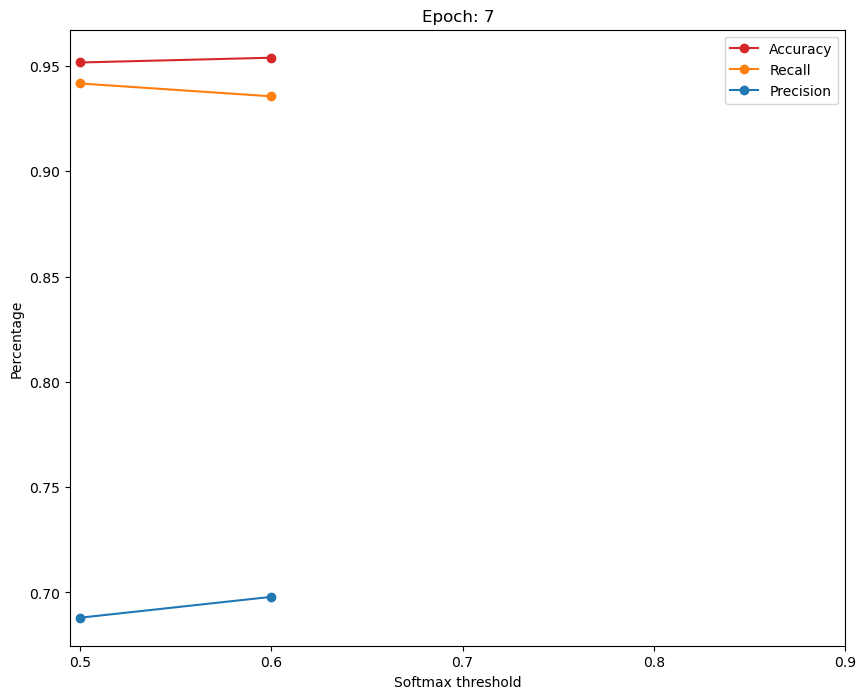

     Softmax Threshold [0.7]
         Image [500/2000], Accuracy: 95.92 %, Recall: 91.65 %, Precision: 73.72 %
         Image [1000/2000], Accuracy: 96.02 %, Recall: 92.22 %, Precision: 74.50 %
         Image [1500/2000], Accuracy: 95.94 %, Recall: 91.96 %, Precision: 74.01 %
         Image [2000/2000], Accuracy: 95.89 %, Recall: 91.79 %, Precision: 73.94 %


total:  64000 correct:  61367 true_pos_obj:  6490 correct_pos_pred:  5957 pos_pred:  8057
Accuracy of the network on the validation images: 95.8859375 % 
Recall of the network on the validation images: 91.7873651771957 % 
Precision of the network on the validation images: 73.93570807993049 % 


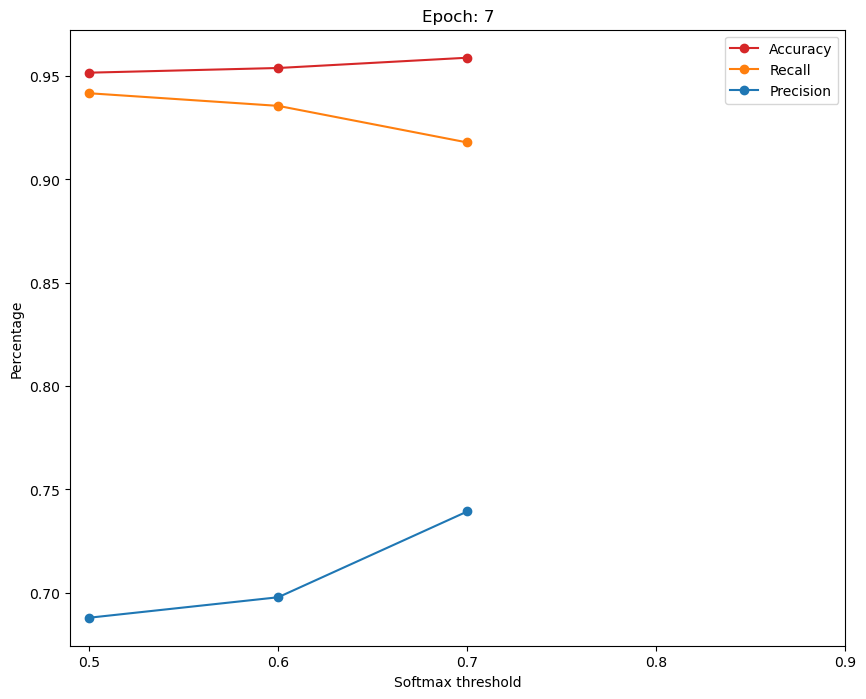

     Softmax Threshold [0.8]
         Image [500/2000], Accuracy: 96.05 %, Recall: 88.38 %, Precision: 75.46 %
         Image [1000/2000], Accuracy: 96.10 %, Recall: 88.51 %, Precision: 76.06 %
         Image [1500/2000], Accuracy: 96.10 %, Recall: 89.35 %, Precision: 75.64 %
         Image [2000/2000], Accuracy: 96.06 %, Recall: 89.33 %, Precision: 75.73 %


total:  64000 correct:  61477 true_pos_obj:  6419 correct_pos_pred:  5734 pos_pred:  7572
Accuracy of the network on the validation images: 96.0578125 % 
Recall of the network on the validation images: 89.32855584982084 % 
Precision of the network on the validation images: 75.72636027469625 % 


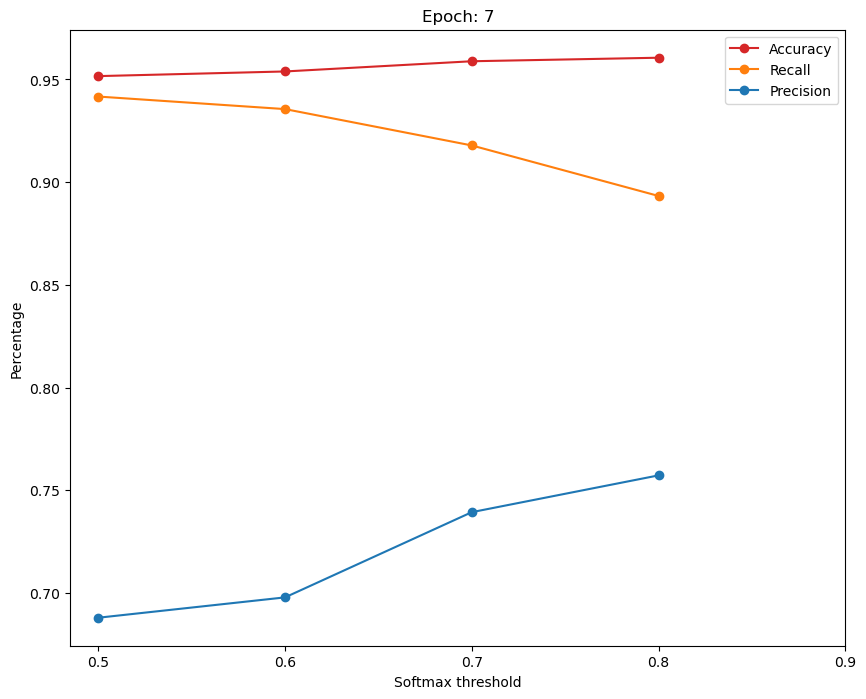

     Softmax Threshold [0.9]
         Image [500/2000], Accuracy: 96.10 %, Recall: 80.55 %, Precision: 80.35 %
         Image [1000/2000], Accuracy: 96.18 %, Recall: 81.08 %, Precision: 80.59 %
         Image [1500/2000], Accuracy: 96.09 %, Recall: 80.47 %, Precision: 80.79 %
         Image [2000/2000], Accuracy: 96.17 %, Recall: 80.90 %, Precision: 81.29 %


total:  64000 correct:  61551 true_pos_obj:  6492 correct_pos_pred:  5252 pos_pred:  6461
Accuracy of the network on the validation images: 96.1734375 % 
Recall of the network on the validation images: 80.89956869993838 % 
Precision of the network on the validation images: 81.28772635814889 % 


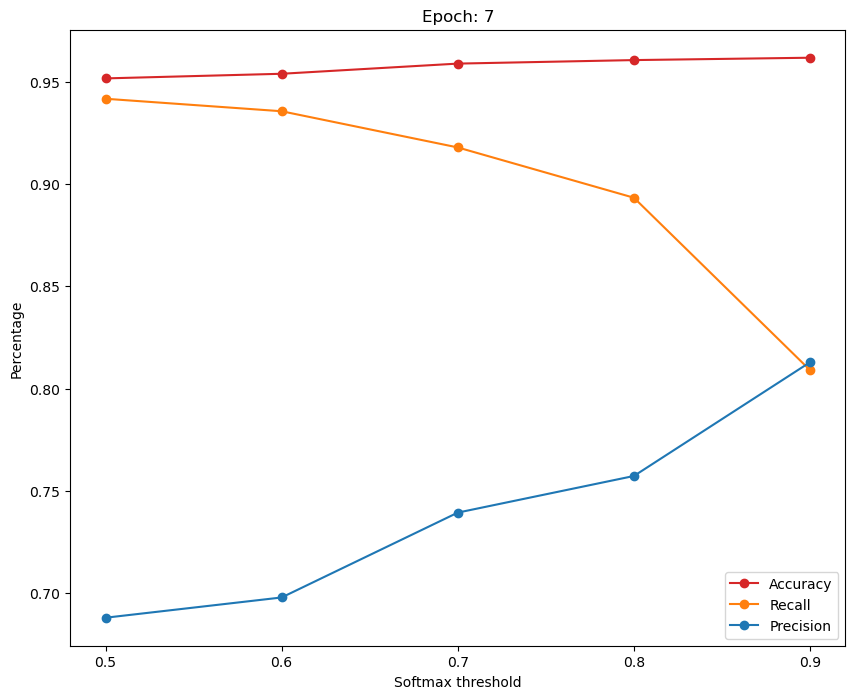

Epoch [8/10]
     Softmax Threshold [0.5]


FileNotFoundError: [Errno 2] No such file or directory: 'rois2/results/model2/round3_model_epoch8.pth'

In [35]:
import torch.nn.functional as F

softmax_thr_list = [0.5, 0.6, 0.7, 0.8, 0.9]
epoch_list = [1,2,3,4,5,6,7,8,9,10]

for epoch in epoch_list:
    print('Epoch [{}/{}]'.format(epoch, len(epoch_list)))
    accuracy_list = [None]*len(softmax_thr_list)
    recall_list = [None]*len(softmax_thr_list)
    precision_list = [None]*len(softmax_thr_list)
    for j, softmax_thr in enumerate(softmax_thr_list):
        print('     Softmax Threshold [{}]'.format(softmax_thr))
        class_model.load_state_dict(torch.load(model2_result_dir + 'round3_model_epoch' + str(epoch) + '.pth'))
        class_model.eval()
        # Calculate accuracy
        correct = 0
        total = 0
        # Calculate recall
        true_pos_obj = 0
        correct_pos_pred = 0
        pos_pred = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(val_loader):
                images = images.to('cuda')
                labels = labels.to('cuda')
                outputs = class_model(images)
                outputs = F.softmax(outputs, dim=1)
                outputs = outputs.cpu().numpy()
                outputs = outputs[:,1]
                predicted = (outputs > softmax_thr).astype(int)
                total += labels.size(0)
                correct += (predicted == labels.cpu().numpy()).sum().item()
                true_pos_obj += (labels != bkg).sum().item()
                correct_pos_pred += ((predicted == labels.cpu().numpy()) & (labels.cpu().numpy() != bkg)).sum().item()
                pos_pred += (predicted != bkg).sum().item()

                if(i+1) % 500 == 0 or i == len(val_loader)-1:
                    print('         Image [{}/{}], Accuracy: {:.2f} %, Recall: {:.2f} %, Precision: {:.2f} %'
                            .format(i+1, len(val_loader), 100 * correct / total, 100 * correct_pos_pred / true_pos_obj, 100 * correct_pos_pred / pos_pred))
        accuracy = correct / total
        recall = correct_pos_pred / true_pos_obj
        precision = correct_pos_pred / pos_pred  
        
        accuracy_list[j] = accuracy
        recall_list[j] = recall
        precision_list[j] = precision
         
        print('\n')        
        print('total: ', total, 'correct: ', correct, 'true_pos_obj: ', true_pos_obj, 'correct_pos_pred: ', correct_pos_pred, 'pos_pred: ', pos_pred)
        print('Accuracy of the network on the validation images: {} % '.format(100 * accuracy))
        print('Recall of the network on the validation images: {} % '.format(100 * recall))
        print('Precision of the network on the validation images: {} % '.format(100 * precision))    
        
        plt.figure(figsize=(10, 8))
        plt.title('Epoch: ' + str(epoch))
        plt.plot(softmax_thr_list, accuracy_list, marker='o',label = 'Accuracy', color='tab:red')
        plt.plot(softmax_thr_list, recall_list, marker='o', label = 'Recall', color='tab:orange')
        plt.plot(softmax_thr_list, precision_list, marker='o', label = 'Precision', color='tab:blue')
        plt.xlabel('Softmax threshold')
        plt.ylabel('Percentage')
        plt.xticks(softmax_thr_list)
        plt.legend()
        plt.show()
        plt.close('all')
        